In [1]:
"""
    Find the resonant state of a system using a convolutional neural network image classification algorithm.
"""
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import rebound
import pandas as pd
pd.set_option("display.precision", 3)

In [2]:
def get_delta(P1,P2,p,q):
    """ Find distance from period ratio P2/P1 to a nominal resonance """
    return (P2/P1) - float(p+q)/float(p)

def find_closest_resonances(P1,P2, nres):
    """ 
        Find closest resonances to a period pair 
        Look at resonances (p+q)/p with p and q up to 10
        Returns a dataframe containing the nearest resonances to P2/P1 and various info
    """
    delta_min=1.
    df = pd.DataFrame(columns=["res", "p", "q", "delta", "delta_abs"])
    for p in range(1,10):
        for q in range(1,10):
            delta = get_delta(P1, P2, p, q)
            res = str(p+q)+':'+str(p)
            df = df.append({'res':res, 'p': p, 'q': q, 'delta': delta, 'delta_abs': np.abs(delta) }, ignore_index=True)

    # Group by resonances (e.g. the 2:1 and the 4:2 go together)
    df["period_ratio"] = (df['p']+df['q'])/df['p']
    df = df.groupby('period_ratio').first().reset_index()
    df = df.nsmallest(nres, 'delta_abs').drop(columns=['delta_abs']).sort_values(by='q')
    print("The two planets have a period ratio", np.round(P2/P1,3), "and are near the following resonances:")
    print(df)
    return df


In [3]:
def get_resonant_angle(p,q,w,l):
    """ 
        Find all the angles associates with a (p+q):p resonance 
        Return the angle and its D'alembert coefficients
    """
    
    theta = np.zeros((len(w), q+1))
    coeffs = []
    for k in range(0,q+1):
        coeffs.append([(p+q), p, k, (q-k)])
        theta[:,k] = (p+q)*l[:,1] - p*l[:,0] - (q-k)*w[:,0] - k*w[:,1]
        theta[:,k] = np.arctan2(np.sin(theta[:,k]), np.cos(theta[:,k]))
    return theta*180/np.pi, coeffs

In [4]:
def plot_all_res(time, theta, pres, qres):
    """ Plot the resonant angles """
    fig, ax = plt.subplots(1,np.shape(theta)[1], figsize=(3*np.shape(theta)[1],3) )
    for k in range(np.shape(theta)[1]):
        ax[k].plot(t, theta[:,k], '.')
        ax[k].set_xlabel('time (yr)')
        ax[k].set_ylabel(r'$\theta_'+str(k+1)+'$')
        ax[k].set_xlim(0, max(t))
        ax[k].set_ylim(-180,180)
    plt.suptitle("resonance "+str(pres+qres)+":"+str(pres) ,fontsize=20)
    plt.tight_layout()

In [5]:
def plot_res(time, angle, plot_name):
    """ Save a specific resonant angle to a png file for further classification by the neural network """
    fig, ax = plt.subplots(figsize=(8.35,8.35))
    ax.plot(time, angle, 'k.')
    ax.set_axis_off()
    ax.set_xlim(np.amin(time), np.amax(time))
    ax.set_ylim(-180,180)
    ax.set_box_aspect(1)
    plt.savefig(plot_name+'.png', format='png', dpi=20, bbox_inches='tight', pad_inches = 0)
    plt.close()
    #plt.show()

In [6]:
def prepare(file):
    """ Creates a low resolution B&W image of the resonant angle to be read by the neural network """
    IMG_SIZE = 128
    img_array = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [7]:
def find_resonance(theta):
    """ 
        Uses the neural network to identify whether the angle is librating or not 
        Returns the category to which the angle belongs (librating around 0, 180, or not librating)
    """
    cat = []
    for k in range(np.shape(theta)[1]):
        file= 'theta'+str(k)
        plot_res(t, theta[:,k], file)
        image = prepare(file+'.png')
        prediction = model.predict([image])
        prediction = list(prediction[0])
        cat.append(CATEGORIES[prediction.index(max(prediction))])
        if cat[k]=='lib0':
            print("Theta_"+str(k+1)+" is librating around 0")
        if cat[k]=='lib180':
            print("Theta_"+str(k+1)+" is librating around 180")
        if cat[k]=='nothing':
            print("Theta_"+str(k+1)+" is not librating")
    return cat

In [8]:
def run_sim(ms,m,a,e,inc,w,O,M):
    """ Run N-body simulation using Rebound """
    
    yr = 2*np.pi
    NP = len(a)
    
    sim = rebound.Simulation()
    sim.integrator = 'ias15'
    
    sim.add(m=ms)
    for k in range(NP):
        sim.add(m=m[k], a=a[k], e=e[k], inc=inc[k], pomega=w[k], Omega=O[k], M=M[k]) 
    sim.dt = 0.01*sim.particles[1].P 
    sim.move_to_com()
    
    tf = 1000*sim.particles[1].P
    n_out = 10000
    times = np.linspace(0, tf, n_out+1)
    P = np.zeros((n_out+1, NP))
    e = np.zeros((n_out+1, NP))
    w = np.zeros((n_out+1, NP))
    l = np.zeros((n_out+1, NP))
    
    for i,t in enumerate(times):
        sim.integrate(t)
        os = sim.calculate_orbits()
        for k in range(NP):
            P[i,k] = os[k].P
            e[i,k] = os[k].e
            w[i,k] = os[k].pomega
            l[i,k] = os[k].l

    return times/yr, P/yr, e, w, l

In [9]:
# Load neural network
CATEGORIES = ["lib0", "lib180", "nothing"]
model = tf.keras.models.load_model("model/CNN.model")

In [10]:
# Give initial conditions
mj = 1./1047.35
me = 1./332946.

a2res=np.power(3./2,2./3)

ms=1.0                # Stellar mass
m=[0.1*mj, 0.3*mj]    # Planet mass
a0=[1.0, 1.014*a2res] # Semi-major axis
e0=[7e-3, 2e-3]       # Eccentricity
i0=[0.0, 0.0]         # Inclination
w0=[0.0, 0.9*np.pi]   # Longitude of pericenter
O0=[0.0, 0.0]         # Longitude of asc. node
M0=[0.0, 1.7*np.pi]   # Mean anomaly

In [11]:
# Run integration
t, P, e, w, l = run_sim(ms,m,a0,e0,i0,w0,O0,M0)

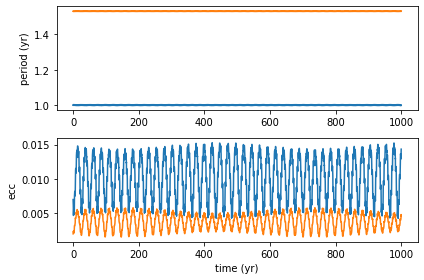

In [12]:
# Vizualize the system
fig, ax = plt.subplots(2,1)
ax[0].plot(t, P)
ax[1].plot(t, e)
ax[1].set_xlabel('time (yr)')
ax[0].set_ylabel('period (yr)')
ax[1].set_ylabel('ecc')
plt.tight_layout()

In [13]:
# Find resonances near the period ratio
nres = 3 # Look at 3 closest resonances
df = find_closest_resonances(P[-1,0],P[-1,1], nres)

The two planets have a period ratio 1.533 and are near the following resonances:
    period_ratio   res  p  q  delta
13         1.500   3:2  2  1  0.033
15         1.571  11:7  7  4 -0.038
14         1.556  14:9  9  5 -0.023


resonance 3 : 2
Theta_1 is librating around 0
Theta_2 is librating around 180

resonance 11 : 7
Theta_1 is not librating
Theta_2 is not librating
Theta_3 is not librating
Theta_4 is not librating
Theta_5 is not librating

resonance 14 : 9
Theta_1 is not librating
Theta_2 is not librating
Theta_3 is not librating
Theta_4 is not librating
Theta_5 is not librating
Theta_6 is not librating



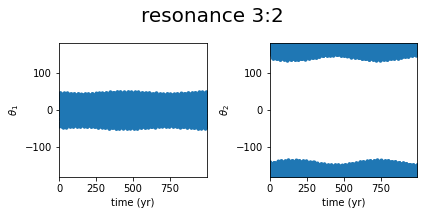

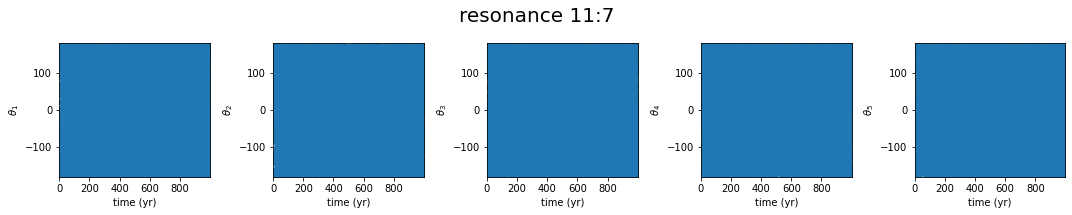

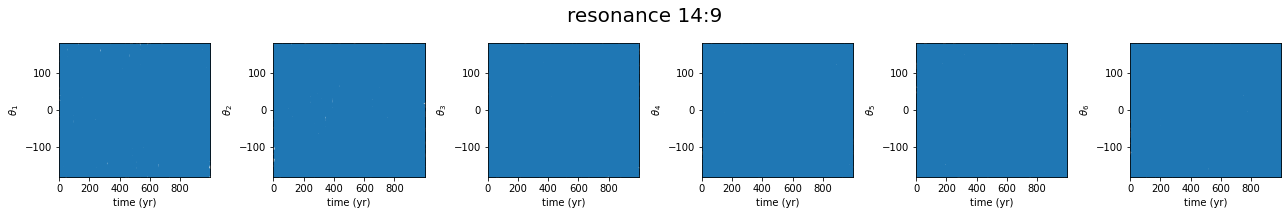

In [14]:
# Plot these resonances and run the neural network to identify librating angles
coeffs_res=[]
for j in range(len(df)):
    pres = df["p"].iloc[j]
    qres = df["q"].iloc[j]
    print("resonance", pres+qres, ":", pres )
    theta, coeffs = get_resonant_angle(pres,qres,w,l)
    plot_all_res(t, theta, pres, qres)
    cat = find_resonance(theta)
    for i,c in enumerate(cat):
        if c=='lib0' or c=='lib180':
            coeffs_res.append(coeffs[i])
    os.system("rm theta*")
    print()


In [15]:
from IPython.display import Latex
print("The following angles are librating:")
for k in range(len(coeffs_res)):
    display(Latex("$%d\lambda_2 - %d\lambda_1 - %d\omega_1 - %d\omega_2$"%(coeffs_res[k][0], coeffs_res[k][1], coeffs_res[k][2],coeffs_res[k][3])) )

The following angles are librating:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>